**Data Engineering Assessment (Oksana Zavada)**<a id='toc0_'></a>    
- [The relational diagram from ERP](#toc1_)    
- [Task 1: Schema Design and Implementation](#toc2_)    
  - [Proposed Schema](#toc2_1_)    
    - [Fact Tables](#toc2_1_1_)    
    - [Dimension Tables](#toc2_1_2_)    
  - [Schema Design Considerations](#toc2_2_)    
    - [Advantages of Star Schema](#toc2_2_1_)    
    - [Disadvantages of Star Schema](#toc2_2_2_)    
  - [Example Analytics Queries](#toc2_3_)    
    - [Revenue Trends by Country and Currency](#toc2_3_1_)    
    - [Customer Activity and Order History](#toc2_3_2_)    
    - [Shipping Performance Analysis](#toc2_3_3_)    
    - [BigQuery-Specific Features](#toc2_3_4_)    
    - [Analytics Effectiveness](#toc2_3_5_)    
  - [Data Correctness and Anomalies](#toc2_4_)    
- [Task 2: Data Pipeline and Quality Assurance](#toc3_)    
  - [Pipeline Steps and GCP Services](#toc3_1_)    
  - [Data Accuracy and Reliability Strategies](#toc3_2_)    
  - [Anomaly Detection and Alerting](#toc3_3_)    
  - [Data Security Considerations](#toc3_4_)    
  - [Pipeline Monitoring and Maintenance](#toc3_5_)    
- [Task 3: ELT with DBT and BigQuery Projects](#toc4_)    
  - [Proposed Architecture](#toc4_1_)    
    - [Structure of BigQuery Projects and Datasets](#toc4_1_1_)    
    - [How dbt Fits into the Workflow](#toc4_1_2_)    
    - [IAM Roles and Permissions](#toc4_1_3_)    
    - [Scalability and Future-Proofing](#toc4_1_4_)    
    - [Example Directory Structure, DBT project](#toc4_1_5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[The relational diagram from ERP](#toc0_)

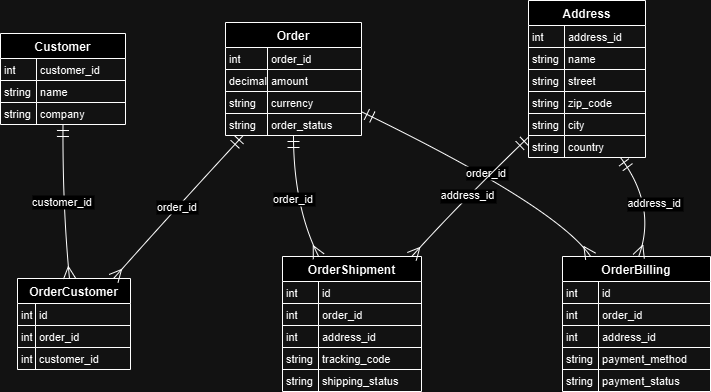

In [1]:
from IPython.display import Image
Image(filename='ERP_DBs.drawio.png')

# <a id='toc2_'></a>[Task 1: Schema Design and Implementation](#toc0_)

**Objectives**

We need a schema that supports flexible analytics on orders, customers, addresses, and related business activities. It should handle multiple business processes, allow for detailed and aggregated analyses, and include fields for data lineage, deletion tracking, and source identification.

**Approach: Star Schema with Multiple Fact Tables**

## <a id='toc2_1_'></a>[Proposed Schema](#toc0_)

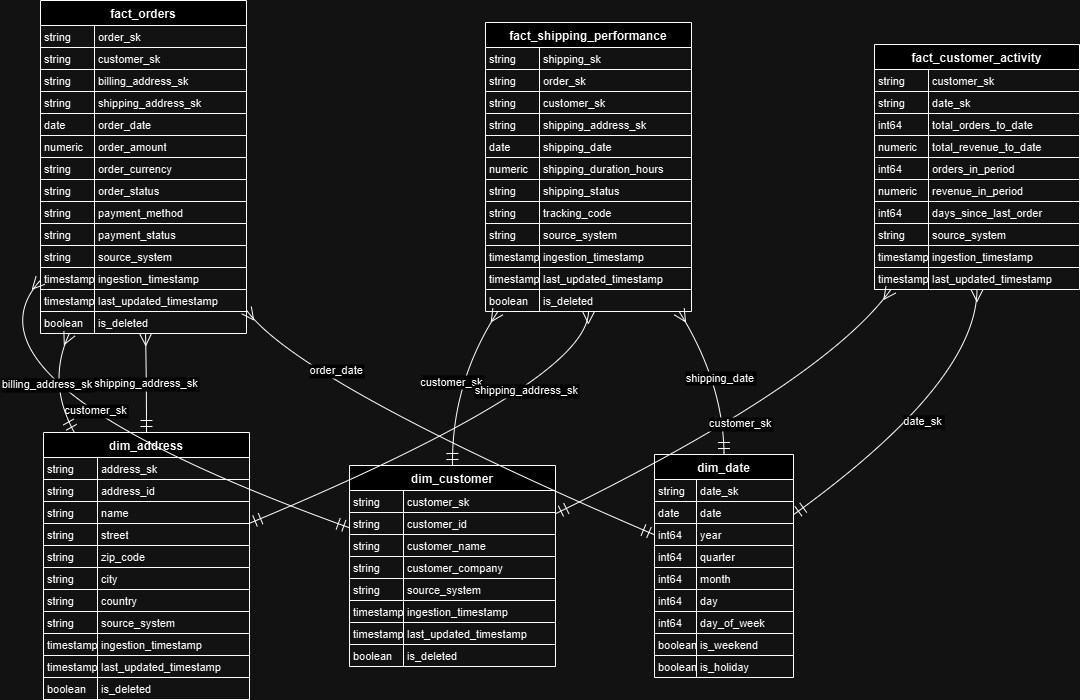

In [2]:
Image(filename='DW.drawio.png')

  
    
     
     
### <a id='toc2_1_1_'></a>[Fact Tables](#toc0_)

1. fact_orders (Granularity: one row per order)
```sql
CREATE TABLE `project_id.dataset.fact_orders` (
  order_sk STRING,
  customer_sk STRING,
  billing_address_sk STRING,
  shipping_address_sk STRING,
  order_date DATE,
  order_amount NUMERIC,
  order_currency STRING,
  order_status STRING,
  payment_method STRING,
  payment_status STRING,
  source_system STRING,
  ingestion_timestamp TIMESTAMP,
  last_updated_timestamp TIMESTAMP,
  is_deleted BOOLEAN
)
PARTITION BY order_date
CLUSTER BY customer_sk;
```

2. fact_shipping_performance (Granularity: one row per order shipment event)
```sql
CREATE TABLE `project_id.dataset.fact_shipping_performance` (
  shipping_sk STRING,
  order_sk STRING,
  customer_sk STRING,
  shipping_address_sk STRING,
  shipping_date DATE,
  shipping_duration_hours NUMERIC,
  shipping_status STRING,
  tracking_code STRING,
  source_system STRING,
  ingestion_timestamp TIMESTAMP,
  last_updated_timestamp TIMESTAMP,
  is_deleted BOOLEAN
)
PARTITION BY shipping_date
CLUSTER BY customer_sk;
```

3. fact_customer_activity (aggregated customer activity data)
```sql
CREATE TABLE `project_id.dataset.fact_customer_activity` (
  customer_sk STRING,
  date_sk STRING,
  total_orders_to_date INT64,
  total_revenue_to_date NUMERIC,
  orders_in_period INT64,
  revenue_in_period NUMERIC,
  days_since_last_order INT64,
  source_system STRING,
  ingestion_timestamp TIMESTAMP,
  last_updated_timestamp TIMESTAMP
)
PARTITION BY date_sk
CLUSTER BY customer_sk;
```

### <a id='toc2_1_2_'></a>[Dimension Tables](#toc0_)

1. dim_customer
```sql
CREATE TABLE `project_id.dataset.dim_customer` (
  customer_sk STRING,
  customer_id STRING,
  customer_name STRING,
  customer_company STRING,
  source_system STRING,
  ingestion_timestamp TIMESTAMP,
  last_updated_timestamp TIMESTAMP,
  is_deleted BOOLEAN
);
```

2. dim_address
```sql
CREATE TABLE `project_id.dataset.dim_address` (
  address_sk STRING,
  address_id STRING,
  name STRING,
  street STRING,
  zip_code STRING,
  city STRING,
  country STRING,
  source_system STRING,
  ingestion_timestamp TIMESTAMP,
  last_updated_timestamp TIMESTAMP,
  is_deleted BOOLEAN
);
```

3. dim_date
```sql
CREATE TABLE `project_id.dataset.dim_date` (
  date_sk STRING,
  date DATE,
  year INT64,
  quarter INT64,
  month INT64,
  day INT64,
  day_of_week INT64,
  is_weekend BOOLEAN,
  is_holiday BOOLEAN
);
```

## <a id='toc2_2_'></a>[Schema Design Considerations](#toc0_)

1. **Multiple Fact Tables**: Implemented separate fact tables for orders, shipping performance, and customer activity to support different business processes and granularities

2. **Surrogate Keys**: Used surrogate keys (SK) for all dimension references in fact tables to support slowly changing dimensions and improve join performance

3. **Tracking Columns**: Added `source_system`, `ingestion_timestamp`, `last_updated_timestamp`, and `is_deleted` to all tables for data lineage and change tracking

4. **Partitioning and Clustering**: Implemented partitioning by date and clustering by frequently filtered columns to optimize query performance.

5. **Numeric Data Type**: Used NUMERIC data type for monetary values to ensure precision in financial calculations

6. **Date Dimension**: Included a comprehensive date dimension to support various time-based analyses

### <a id='toc2_2_1_'></a>[Advantages of Star Schema](#toc0_)
1. Simpler design and easier to understand
2. Faster query execution due to fewer joins
3. Efficient for common analytical queries and reporting

### <a id='toc2_2_2_'></a>[Disadvantages of Star Schema](#toc0_)
1. Data redundancy and increased storage requirements
2. Potential data integrity issues due to denormalization
3. Limited support for complex relationships and hierarchies

## <a id='toc2_3_'></a>[Example Analytics Queries](#toc0_)

### <a id='toc2_3_1_'></a>[Revenue Trends by Country and Currency](#toc0_)
calculates total revenue and assesses month-over-month growth rates
```sql
SELECT
  a.country,
  f.order_currency,
  d.year,
  d.month,
  SUM(f.order_amount) AS total_revenue,
  LAG(SUM(f.order_amount)) OVER (PARTITION BY a.country, f.order_currency ORDER BY d.year, d.month) AS prev_month_revenue,
  (SUM(f.order_amount) - LAG(SUM(f.order_amount)) OVER (PARTITION BY a.country, f.order_currency ORDER BY d.year, d.month)) / 
    LAG(SUM(f.order_amount)) OVER (PARTITION BY a.country, f.order_currency ORDER BY d.year, d.month) AS mom_growth_rate
FROM `project_id.dataset.fact_orders` f
JOIN `project_id.dataset.dim_address` a ON f.shipping_address_sk = a.address_sk
JOIN `project_id.dataset.dim_date` d ON f.order_date = d.date
WHERE d.date >= DATE_SUB(CURRENT_DATE(), INTERVAL 1 YEAR)
GROUP BY a.country, f.order_currency, d.year, d.month
ORDER BY a.country, f.order_currency, d.year DESC, d.month DESC
```

### <a id='toc2_3_2_'></a>[Customer Activity and Order History](#toc0_)
1. Cohort Analysis: Groups customers by their first purchase month (cohort).
2. Customer Lifetime Value (CLV) Analysis: Tracks revenue and orders over time since the first purchase.
3. Retention Rate Calculation: Measures the percentage of customers making repeat purchases in each month.
4. Window Functions: Uses DATE_DIFF to calculate months since first purchase.
5. Aggregations: Performs various aggregations like COUNT, SUM, and AVG for detailed metrics.
```sql
WITH customer_cohorts AS (
  SELECT
    c.customer_sk,
    c.customer_name,
    MIN(d.date) AS first_purchase_date,
    DATE_TRUNC(MIN(d.date), MONTH) AS cohort_month
  FROM `project_id.dataset.fact_customer_activity` f
  JOIN `project_id.dataset.dim_customer` c ON f.customer_sk = c.customer_sk
  JOIN `project_id.dataset.dim_date` d ON f.date_sk = d.date_sk
  WHERE f.total_orders_to_date > 0
  GROUP BY c.customer_sk, c.customer_name
),
customer_activity AS (
  SELECT
    cc.customer_sk,
    cc.customer_name,
    cc.cohort_month,
    d.date,
    f.total_orders_to_date,
    f.total_revenue_to_date,
    f.orders_in_period,
    f.revenue_in_period,
    DATE_DIFF(d.date, cc.first_purchase_date, MONTH) AS months_since_first_purchase
  FROM customer_cohorts cc
  JOIN `project_id.dataset.fact_customer_activity` f ON cc.customer_sk = f.customer_sk
  JOIN `project_id.dataset.dim_date` d ON f.date_sk = d.date_sk
)
SELECT
  cohort_month,
  months_since_first_purchase,
  COUNT(DISTINCT customer_sk) AS cohort_size,
  SUM(revenue_in_period) AS total_revenue,
  SUM(orders_in_period) AS total_orders,
  AVG(revenue_in_period) AS avg_revenue_per_customer,
  SUM(CASE WHEN orders_in_period > 0 THEN 1 ELSE 0 END) / COUNT(DISTINCT customer_sk) AS retention_rate
FROM customer_activity
GROUP BY cohort_month, months_since_first_purchase
ORDER BY cohort_month, months_since_first_purchase
```

### <a id='toc2_3_3_'></a>[Shipping Performance Analysis](#toc0_)
analyzing key metrics such as the number of delayed shipments, total shipments, and delay rates across different countries
```sql
SELECT
  a.country,
  d.year,
  d.quarter,
  COUNT(*) AS total_shipments,
  AVG(sp.shipping_duration_hours) AS avg_shipping_duration,
  COUNTIF(sp.shipping_status = 'Delayed') AS delayed_shipments,
  COUNTIF(sp.shipping_status = 'Delayed') / COUNT(*) AS delay_rate
FROM `project_id.dataset.fact_shipping_performance` sp
JOIN `project_id.dataset.dim_address` a ON sp.shipping_address_sk = a.address_sk
JOIN `project_id.dataset.dim_date` d ON sp.shipping_date = d.date
GROUP BY a.country, d.year, d.quarter
ORDER BY a.country, d.year DESC, d.quarter DESC
```

These queries leverage the star schema design, utilizing dimension tables for efficient filtering and grouping, while maintaining the ability to perform complex analytical calculations using window functions.

### <a id='toc2_3_4_'></a>[BigQuery-Specific Features](#toc0_)

1. **Partitioning**: Used DATE-based partitioning for fact tables to improve query performance and reduce costs

2. **Clustering**: Implemented clustering on frequently filtered columns to enhance query speed

3. **Numeric Data Type**: Utilized BigQuery's NUMERIC type for precise decimal calculations

4. **Date Functions**: Leveraged BigQuery's built-in date functions for the dim_date table

### <a id='toc2_3_5_'></a>[Analytics Effectiveness](#toc0_)

1. **Granular Data**: Stored data at the most granular level in fact tables, allowing for flexible aggregations

2. **Conformed Dimensions**: Used conformed dimensions across fact tables for consistent reporting

3. **Performance Metrics**: Included specific performance metrics in fact tables (e.g., shipping_duration_hours, days_since_last_order) to support detailed analytics

4. **Time Series Analysis**: The dim_date table enables comprehensive time-based analysis across all fact tables

This schema design provides a robust foundation for analytics, leveraging BigQuery's features for optimal performance and scalability. It addresses the requirements for tracking data lineage, supporting multiple business processes, and enabling detailed time-based analytics

## <a id='toc2_4_'></a>[Data Correctness and Anomalies](#toc0_)

Considerations:

- Use NOT NULL constraints for required fields
- Add CHECK constraints for valid values (e.g., amount > 0)
- Foreign Key Integrity: Ensure that customer_id in fact_orders always matches a row in dim_customer. Same for address_id
- Currency Consistency: Check currency codes against a known list
- Valid Status Values: Validate order_status, payment_status, and shipping_status against predefined enumerations
- Delayed Updates: Ensure timely updates to order statuses
- Outlier Detection in Amounts: Flag orders that have amounts significantly higher or lower than historical averages
- Missing Data Checks, Dublicates Check
- Create a separate table for data quality issues with information like 
    table_name, column_name, record_id, issue_type, issue_description, detected_at
- Implement data quality checks in the pipeline 
- Use BigQuery's MERGE statement for upserts to handle updates and avoid duplicates

# <a id='toc3_'></a>[Task 2: Data Pipeline and Quality Assurance](#toc0_)

This pipeline is designed to reliably ingest, transform, and store ERP data in BigQuery. It ensures data accuracy, handles incremental and late-arriving records, and integrates data quality checks with anomaly detection and alerting. All components leverage GCP’s managed services for scalability, security, and maintainability.

## <a id='toc3_1_'></a>[Pipeline Steps and GCP Services](#toc0_)

### **Updated Pipeline Steps and GCP Services**

1. **Data Extraction (Cloud Run + Cloud Scheduler)**  
   - **Cloud Scheduler** triggers **Cloud Run** at regular intervals to call the ERP API.  
   - Extracted JSON data is validated against a predefined schema (e.g., using JSON Schema) to confirm field presence and types.  
   - Successful responses are written to Cloud Storage for raw staging. If validation fails, the service logs the issue and sends an alert.  
   - **Cloud Run** It supports concurrency, auto-scaling, and longer execution times, making it more scalable and cost-effective.  
   - **Optional: Event-Driven Extraction with Pub/Sub**:  
  - If the ERP system supports webhooks, use **Pub/Sub** to trigger data extraction.  
  - Benefits: Eliminates polling, reduces latency, and improves efficiency.  

2. **Data Staging (Cloud Storage)**  
   - Raw data is stored in GCS buckets, partitioned by ingestion date for incremental loading.  
   - Each file includes metadata (source system, extraction timestamps) for lineage and data quality checks.  

3. **Data Loading and Transformation (Cloud Dataflow)**  
   - **Cloud Dataflow** reads from GCS, processes data in parallel, and applies:  
     - Data type checks and business rules.  
     - Referential integrity checks (e.g., validating `customer_id` against `dim_customer`).  
     - Windowing and triggers for handling late-arriving records.  
   - Records failing validation are sent to a dead-letter queue for review.  
   - Cleaned and enriched data is loaded into BigQuery using **MERGE** operations for idempotent updates.  
   For optimization use **Splittable DoFn** for efficient parallel processing and **BigQuery Storage Write API** for faster loading. 

4. **Data Warehousing (BigQuery)**  
   - BigQuery stores raw and transformed tables, partitioned and clustered for cost-effective querying.  
   - Periodic **MERGE** operations build curated, analytics-ready tables.  
   - Additional data quality checks (e.g., uniqueness, non-null constraints) are applied using tools like **dbt**.  
   Implement **materialized views** and **BI Engine** for faster analytics.  

5. **Orchestration and Workflow Management (Cloud Composer)**  
   - **Cloud Composer (Apache Airflow)** manages DAGs for extraction, Dataflow jobs, and BigQuery transformations.  
   - Dependencies ensure transformations run only after raw data loads are complete.  
   - Failed steps trigger alerts, retries, or dead-letter queues for manual intervention.  
   For optimization use **Task Groups** and **sensors** to simplify DAGs and handle dependencies.  


## <a id='toc3_2_'></a>[Data Accuracy and Reliability Strategies](#toc0_)

1. **Schema and Data Type Validation**  
   Validate API responses against a JSON Schema and apply strict data type checks in Dataflow. Non-conforming records are quarantined

2. **Referential Integrity Checks**  
   Dataflow joins reference data (e.g., known customers, addresses) to confirm foreign keys. Invalid records are flagged and not loaded into final tables until resolved

3. **Idempotent Loads and Incremental Logic**  
   Dataflow pipelines track the maximum processed timestamps. Late arrivals are handled gracefully, ensuring no double-counting or missing data

4. **Checksums and Reconciliation**:  
   Regular reconciliation queries in BigQuery compare counts and checksums of staged data vs. source logs, ensuring completeness

## <a id='toc3_3_'></a>[Anomaly Detection and Alerting](#toc0_)

1. **Anomaly Detection**:  
   - Dataflow jobs maintain rolling averages and standard deviations for key metrics  
   - Outliers trigger anomaly flags stored in a separate monitoring table in BigQuery
   - Time series forecasting (via BigQuery ML) can also be used to identify unexpected patterns (e.g., a sudden drop in daily orders)

2. **Alert Integration**:  
   - **Cloud Monitoring** watches these anomaly flags and pipeline performance metrics
   - If anomalies exceed predefined thresholds or if error counts are too high, Cloud Monitoring alerts are sent to on-call channels (e.g., email, Slack, PagerDuty)
   - This real-time feedback loop allows data engineers to investigate and fix issues promptly

## <a id='toc3_4_'></a>[Data Security Considerations](#toc0_)

1. **Encryption (Cloud KMS)** 
   All data is encrypted at rest and in transit. Sensitive fields (like PII) can be masked or stored separately with column-level encryption keys

2. **Access Control (IAM)**
   Fine-grained IAM roles restrict access to raw vs. curated datasets. Only authorized individuals or services can query sensitive tables

3. **Audit Logging and Metadata Management** 
   Detailed logs in Cloud Logging and audit logs track who accessed what data and when. This ensures compliance and traceability

4. **Secure API Authentication**:  
   OAuth 2.0 and service accounts with limited permissions are used to access ERP endpoints securely

## <a id='toc3_5_'></a>[Pipeline Monitoring and Maintenance](#toc0_)

1. **Custom Metrics and SLOs**  
   Cloud Monitoring dashboards show pipeline throughput, latency, and error rates. Defined SLOs (e.g., 99.9% of data processed within an hour) help measure performance against targets

2. **Retry Policies and Dead-letter Queues**  
   If a Dataflow job encounters errors (like invalid data), it retries up to a limit. Persistent failures route messages to a dead-letter queue in GCS or Pub/Sub for manual review

3. **Continuous Improvement**  
   The pipeline is built to be flexible. Configuration and code changes are deployed through a CI/CD pipeline, and new checks or transformations can be added easily as business needs evolve

# <a id='toc4_'></a>[Task 3: ELT with DBT and BigQuery Projects](#toc0_)

## <a id='toc4_1_'></a>[Proposed Architecture](#toc0_)

**Key Principles:**

1. **Separation of Environments**  
   - **Raw Project**: Contains raw and lightly processed tables from the ERP source. Access is restricted mainly to data engineers
   - **Sandbox Project**: A development space where engineers and analysts can test new transformations, experiments, and data models without impacting production
   - **Production Project**: Holds clean, curated, production-ready tables and views, which business users and visualization tools can access confidently

2. **ELT with dbt**  
   - **Extract and Load**: As described in Task 2, raw data is extracted via Cloud Functions and loaded into the Raw Project’s BigQuery dataset using Dataflow
   - **Transform with dbt**: dbt runs SQL transformations inside BigQuery. It reads from the Raw Project’s datasets, writes intermediate models to the Sandbox Project during development, and deploys final, validated models to the Production Project
   - **Data Quality Tests**: dbt tests enforce data integrity (e.g., unique keys, non-null fields) on each run. These tests leverage metadata columns (`source_system`, `ingestion_timestamp`, `is_deleted`) for auditing and tracking changes

3. **Security and Access Controls**
   - **Raw Project**:  
     - Engineers have full access to manipulate raw data, manage tables, and apply transformations
     - Other teams do not have direct access, ensuring raw and possibly sensitive data is protected
   - **Sandbox Project**:  
     - Developers and data engineers can create and modify tables, run dbt tests, and experiment with transformations
     - Restricted to technical users; business analysts may have read access for review, but no write permissions
   - **Production Project**:  
     - Analysts, BI tools, and other downstream consumers get read access to curated tables and authorized views only
     - Engineers maintain permissions to update schema and deploy new dbt models, but day-to-day analyst queries do not require direct contact with raw data

### <a id='toc4_1_1_'></a>[Structure of BigQuery Projects and Datasets](#toc0_)

1. **`project_id_raw`**:  
   - **Datasets:** `raw_dataset` (staging zone for ERP data, as per Task 2 pipeline)  
   - **Content:** Raw, unmodified ERP tables (`orders_raw`, `customers_raw`, etc.)

2. **`project_id_sandbox`**:
   - **Datasets:** `sandbox_dataset` for intermediate models, prototypes, and testing
   - **Content:** dbt models that are not yet production-ready. Engineers can iterate quickly, run tests, and validate transformations. If tests fail or data looks suspicious, it can be fixed here without impacting production

3. **`project_id_prod`**:
   - **Datasets:** `prod_dataset` for the final curated schema as defined in Task 1 (e.g., `fact_orders`, `fact_shipping_performance`, `fact_customer_activity`, `dim_customer`, `dim_address`, `dim_date`)
   - **Content:** Production-grade tables that analysts and BI tools query. These incorporate all lineage, quality checks, incremental loads from Task 2, and follow the star schema from Task 1

### <a id='toc4_1_2_'></a>[How dbt Fits into the Workflow](#toc0_)

1. **ELT Phases**
   - **Extract/Load (From Task 2)**: Data pipeline extracts ERP data and loads it into the `project_id_raw.raw_dataset`
   - **Transform (Now with dbt)**:
     - dbt reads from `project_id_raw.raw_dataset`
     - During development, models are built in `project_id_sandbox.sandbox_dataset`. Teams run `dbt run` and `dbt test` here to verify logic
     - Once validated, models are deployed to `project_id_prod.prod_dataset`. dbt’s `run` commands in a production environment build final fact and dimension tables (e.g., `fact_orders`, `dim_customer`) that follow the star schema and incorporate incremental logic for late-arriving data

2. **Incremental Models and Tests:**
   - dbt can implement incremental logic using `MERGE` statements in BigQuery, handling late-arriving records and updates cleanly. This aligns with the incremental data handling strategies defined in Task 2
   - dbt tests ensure the data adheres to quality rules (non-null, unique keys, valid enum values), catching issues early. If tests fail, the model does not move to production

3. **Documentation and Data Cataloging:**
   - dbt automatically generates documentation, including lineage graphs and table descriptions
   - Combined with metadata fields (e.g., `source_system`, `last_updated_timestamp`), this gives analysts a clear view of where data comes from and how recent it is

### <a id='toc4_1_3_'></a>[IAM Roles and Permissions](#toc0_)

- **Raw Project (project_id_raw)**:
  - **Engineers**: `roles/bigquery.dataOwner` or `roles/bigquery.admin` to manage raw ingestion and schema evolution
  - **Others**: No access by default. Sensitive raw data remains protected

- **Sandbox Project (project_id_sandbox)**:
  - **Engineers/Developers**: `roles/bigquery.dataEditor` to create and modify test tables and views
  - **Analysts**: Possibly `roles/bigquery.dataViewer` for read-only access if needed for QA

- **Production Project (project_id_prod)**:
  - **Engineers**: `roles/bigquery.dataOwner` to maintain and update final production tables and deploy dbt models
  - **Analysts, BI Tools**: `roles/bigquery.dataViewer` on `prod_dataset` to run analytical queries. They see only the curated tables, not raw or sandbox data
  - **Other Teams**: Limited to specific authorized views or datasets as needed, ensuring no direct exposure to raw or test data

### <a id='toc4_1_4_'></a>[Scalability and Future-Proofing](#toc0_)

- By separating environments into distinct projects, each layer of the data workflow can scale independently. Engineers can focus on ingestion and raw data quality without affecting production users
- The sandbox environment encourages experimentation. New metrics (e.g., adding a new fact table for a new business process) can be tested and validated in the sandbox before being promoted
- Production datasets remain stable and trusted, ensuring that performance and cost optimizations (like partitioning, clustering) are applied once models have matured

### <a id='toc4_1_5_'></a>[Example Directory Structure, DBT project](#toc0_)

- **Dimensions**: Contain attributes that describe the entities in your business domain (e.g., customers, addresses, products, dates).
They are relatively stable and often reused by multiple fact tables
- **Facts**: Contain measurable events or transactions (e.g., orders, shipments, customer activities). They often reference keys from multiple dimensions

```
models/
  ├─ staging/
  │  ├─ source.yml
  │  ├─ stg_erp_orders.sql
  │  ├─ stg_erp_customers.sql
  │  └─ ...
  │
  ├─ integration/          # optional layer
  │  ├─ int_orders_enriched.sql
  │  ├─ int_customers_enriched.sql
  │  └─ ...
  │
  ├─ marts/
  │  └─ core/
  │     ├─ dimensions/
  │     │  ├─ dim_customer.sql
  │     │  ├─ dim_address.sql
  │     │  ├─ dim_date.sql
  │     │  └─ schema.yml     # tests/docs for dimensions
  │     │
  │     ├─ facts/
  │     │  ├─ fact_orders.sql
  │     │  ├─ fact_shipping_performance.sql
  │     │  ├─ fact_customer_activity.sql
  │     │  └─ schema.yml     # tests/docs for facts
  │     │
  │     ├─ bridges/
  │     │  ├─ customer_region_bridge.sql
  │     │  └─ schema.yml     # tests/docs for bridge tables
  │     │
  │     └─ schema.yml        # optional top-level schema file if needed
  │
  ├─ tests/                  # singular SQL tests and generic tests
  │  ├─ test_no_future_orders.sql
  │  ├─ test_anomalies_in_fact_orders.sql
  │  └─ ...
  │
  ├─reports/
  │  ├─ revenue_trends.sql
  │  └─ ...
  │
  ├─ macros/
  ├─ seeds/
  └─ dbt_project.yml
  ```